Now that we've covered [regression](/posts/xgboost-for-regression-in-python/),
it's high time for a tutorial on solving classification problems in python with XGBoost.
Today we'll run through two examples: one for binary classification and another for multi-class classification.
We're going to use nearly ready-to-train datasets from the scikit-learn datasets module for illustration, so check out my tutorial on regression for [details on preparing data for XGBoost](/posts/xgboost-for-regression-in-python/#prepare-raw-data-for-xgboost).
After covering the training APIs from both scikit-learn and the native xgboost python library, we'll have a look at some performance metrics specific to both binary and multiclass classification.

Since you're reading this tutorial, you might also enjoy a deep dive on [the math behind XGBoost](/posts/xgboost-explained/)
or [the implementation details of multi-class gradient boosting](/posts/gradient-boosting-multi-class-classification-from-scratch/),
or you might even want to check out my [full series on gradient boosting](/gradient-boosting-series/).

![A blistering afternoon in the Masai Mara](xgboost-classification-main.jpg "")

## Binary Classification with XGBoost

We'll demonstrate binary classification in XGBoost using the
[breast cancer wisconsin data](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer),
one of scikit-learn's built-in toy datasets.
This is a tiny dataset with 569 observations of 30 features and a binary target.

In [187]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn import datasets

dbunch = datasets.load_breast_cancer(as_frame=True)
df = dbunch.frame
features = dbunch.feature_names 
target = 'target' 
target_names = dbunch.target_names 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

The features are all numeric, so no need to do preprocessing before passing to XGBoost.
Let's have a look at the target.

In [188]:
df[target].unique(), target_names

(array([0, 1]), array(['malignant', 'benign'], dtype='<U9'))

For binary classification, XGBoost requires that the target takes values in {0, 1},
and we can see our data already satisfies that condition.
Let's check the counts of observations in each class.



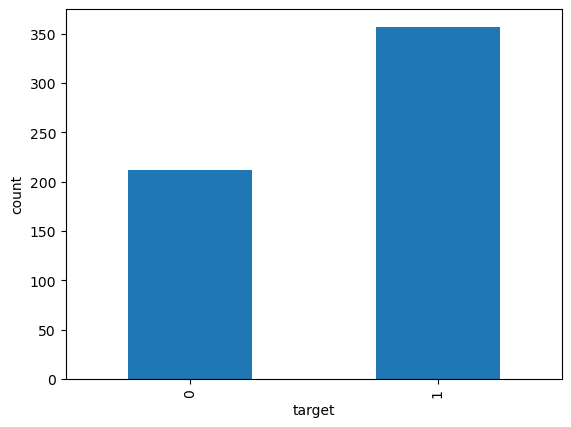

In [189]:
#| fig-alt: bar plot showing the count of observations in each class
#| fig-cap: class counts for the breast cancer dataset

df.target.value_counts().sort_index().plot.bar()
plt.xlabel('target') 
plt.ylabel('count');

Next We split data into train and validation sets.
On a real problem we'd choose the validation set either randomly or based on temporal ordering of the data, but for this toy problem, we just grab the last few rows of the dataset for validation.

In [190]:
n_valid = 50 

train_df, valid_df = df[:-n_valid], df[-n_valid:] 
train_df.shape, valid_df.shape

((519, 31), (50, 31))

### Binary Classification Training APIs

The `xgboost` python library offers two API's for training classification models: the native `train` function and a wrapper class called `XGBClassifier`, which offers an API consistent with the scikit-learn universe.
I'll show you how to use both approaches, but if you're planning to use other utilities from scikit-learn, you might find the `XGBClassifier` approach to be more convenient, since the trained model object will generally play nice with sklearn functionality.

I like to set the 
[XGBoost parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)
in a dictionary;
be sure to set `objective` to `binary:logistic` so XGBoost uses negative log likelihood instead of the default mean squared error.

#### The native XGBoost `train` function

The `train` function requires you to te create `DMatrix` objects for training and validation data prior to training.

In [191]:
params = {
    'tree_method': 'exact',
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'binary:logistic',
    # 'num_class': df[target].nunique()
}
num_boost_round = 50

dtrain = xgb.DMatrix(label=train_df[target], data=train_df[features])
dvalid = xgb.DMatrix(label=valid_df[target], data=valid_df[features])
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  verbose_eval=10)

[0]	train-logloss:0.46304	valid-logloss:0.47318


[10]	train-logloss:0.04542	valid-logloss:0.08636
[20]	train-logloss:0.01542	valid-logloss:0.05761
[30]	train-logloss:0.00986	valid-logloss:0.04896
[40]	train-logloss:0.00779	valid-logloss:0.04021
[49]	train-logloss:0.00672	valid-logloss:0.03738


#### Training using the `XGBClassifier` wrapper

In [192]:
params = {
    'tree_method': 'exact',
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'binary:logistic',
}
num_boost_round = 50

# scikit-learn interface
clf = xgb.XGBClassifier(n_estimators=num_boost_round, **params)
clf.fit(train_df[features], train_df[target], 
        eval_set=[(train_df[features], train_df[target]), (valid_df[features], valid_df[target])], 
        verbose=10);

[0]	validation_0-logloss:0.46304	validation_1-logloss:0.47318


[10]	validation_0-logloss:0.04542	validation_1-logloss:0.08636
[20]	validation_0-logloss:0.01542	validation_1-logloss:0.05761
[30]	validation_0-logloss:0.00986	validation_1-logloss:0.04896
[40]	validation_0-logloss:0.00779	validation_1-logloss:0.04021
[49]	validation_0-logloss:0.00672	validation_1-logloss:0.03738


### Evaluating XGBoost Binary Classification Performance

We'll use the `sklearn.metrics` module
to evaluate model performance on the held-out validation set.
Have a look at the 
[scikit-learn metrics for c]lassification](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)
for examples of other metrics to use.

One thing to watch out for when computing metrics is the difference between the actual labels (usually called `y_true`), the model's predicted labels (usually called `y_pred`), and the models predicted probabilities (usually called `y_score`).
If you're using the `XGBClassifier` wrapper, you can get predicted labels with the `predict` method and predicted probabilities with the `predict_proba` method.
Also note that whereas `predict` returns a vector of size (num data), `predict_proba` returns a vector of size (num data, num classes); thus for binary classification, we'll take just the second column of the array which gives the probability of class 1.

In [193]:
from sklearn import metrics 

y_true = valid_df[target]
y_pred = clf.predict(valid_df[features])
y_score = clf.predict_proba(valid_df[features])[:,1]

Probably the simplest classification metric is accuracy, the proportion of labels we predicted correctly.
This is an easy problem, and our model got 100% of the validation samples correct.

In [194]:
metrics.accuracy_score(y_true, y_pred)

1.0

We can generate a classification report with several different metrics at once.

In [195]:
print(metrics.classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   malignant       1.00      1.00      1.00        10
      benign       1.00      1.00      1.00        40

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



And we can compute the AUC, a popular classification metric based on the ROC curve, which depends on the predicted probability rather than the labels yielded by applying a particular threshold to the probabilities.

In [196]:
metrics.roc_auc_score(y_true, y_score)

1.0

## Multi-Class Classification with XGBoost

We'll illustrate multi-class classification using the 
[scikit-learn forest cover type dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html#sklearn.datasets.fetch_covtype),
which has around 580k observations of 54 features and a target with 7 classes.

In [197]:
dbunch = datasets.fetch_covtype(as_frame=True)
df = dbunch.frame
features = dbunch.feature_names 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

Text(0, 0.5, 'count')

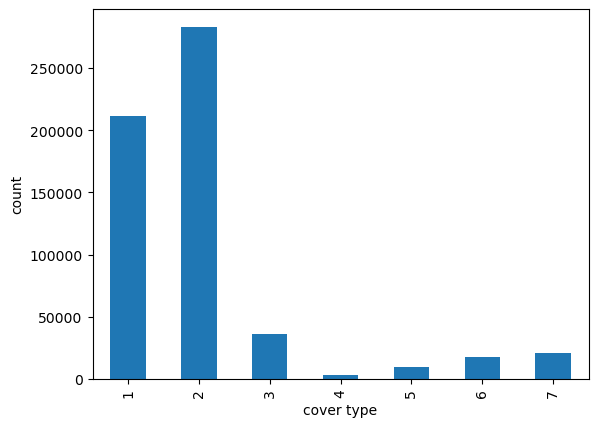

In [198]:
#| fig-alt: bar plot showing the count of observations in each class
#| fig-cap: class counts for the forest cover type dataset

df['Cover_Type'].value_counts().sort_index().plot.bar();
plt.xlabel('cover type') 
plt.ylabel('count')

For multi-class classification, our target variable must take values in $\{0,1,\dots,K\}$.
However, from the histogram of the cover type above, we see that it takes values in $\{1,2,\dots,7\}$.
To fix this we can use the scikit-learn label encoder to create a well-formed target column.

In [199]:
from sklearn.preprocessing import LabelEncoder 

target = 'encoded'
enc = LabelEncoder()
df[target] = enc.fit_transform(df['Cover_Type'])

This time, let's actually randomly sample a validation set.

In [200]:
def train_test_split_random(df, n_valid):
    np.random.seed(42)
    idx_sort = np.random.permutation(len(df))
    idx_train, idx_test = idx_sort[:-n_valid], idx_sort[-n_valid:]
    return df.iloc[idx_train, :], df.iloc[idx_test, :]

train_df, valid_df = train_test_split_random(df, 20000)
train_df.shape, valid_df.shape

((561012, 56), (20000, 56))

### Training APIs for Multi-Class Classification 

Just like in binary classification, we can choose to use either the native `train` function or the sklearn-like `XGBClassifier` wrapper to train XGBoost.

#### Training with the native XGBoost `train` function

If you're training with the `train` function, multi-class classification can be done with two objectives: `multi:softmax` and `multi:softprob`. 
Both use the same loss function, negative multinomial log likelihood, but the softmax option produces a trained `Booster` object whose predict method returns a 1d array of predicted labels, whereas the softprob option produces a trained `Booster` object whose predict method returns a 2d array of predicted probabilities.
In either case, you also need to explicitly tell XGBoost how many classes the target has with the `num_class` parameter.

In [201]:
params = {
    'tree_method': 'approx',
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'multi:softprob',
    'num_class': df[target].nunique()
}
num_boost_round = 10

dtrain = xgb.DMatrix(label=train_df[target], data=train_df[features])
dvalid = xgb.DMatrix(label=valid_df[target], data=valid_df[features])
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  verbose_eval=2)

[0]	train-mlogloss:1.42072	valid-mlogloss:1.42131
[2]	train-mlogloss:1.00455	valid-mlogloss:1.00535
[4]	train-mlogloss:0.80579	valid-mlogloss:0.80711
[6]	train-mlogloss:0.69510	valid-mlogloss:0.69636
[8]	train-mlogloss:0.62767	valid-mlogloss:0.62970
[9]	train-mlogloss:0.60207	valid-mlogloss:0.60393


#### Training using the scikit-learn `XGBClassifier` wrapper

In multi-class classification, I think  the scikit-learn `XGBClassifier` wrapper is quite a bit more convenient than the native `train` function.
You can set the `objective` parameter to `multi:softprob`, and `XGBClassifier.fit` will produce a model having both `predict` and `predict_proba` methods.
Also there is no need to explicitly set the number of classes in the target and no need to create the `DMatrixG objects.`

In [202]:
params = {
    'tree_method': 'approx',
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'multi:softprob',
}
num_boost_round = 10

# scikit-learn interface
clf = xgb.XGBClassifier(n_estimators=num_boost_round, **params)
clf.fit(train_df[features], train_df[target], 
        eval_set=[(train_df[features], train_df[target]), (valid_df[features], valid_df[target])], 
        verbose=2);

[0]	validation_0-mlogloss:1.42072	validation_1-mlogloss:1.42131
[2]	validation_0-mlogloss:1.00455	validation_1-mlogloss:1.00535
[4]	validation_0-mlogloss:0.80579	validation_1-mlogloss:0.80711
[6]	validation_0-mlogloss:0.69510	validation_1-mlogloss:0.69636
[8]	validation_0-mlogloss:0.62767	validation_1-mlogloss:0.62970
[9]	validation_0-mlogloss:0.60207	validation_1-mlogloss:0.60393


### Evaluating XGBoost Multi-Class Classification 

Here again we can use the `sklearn.metrics` module to compute classification metrics to evaluate our model.
This time, we'll kee; the entire 2d `y_score` array of predicted probabilities.

In [203]:
y_true = valid_df[target]
y_pred = clf.predict(valid_df[features])
y_score = clf.predict_proba(valid_df[features])
y_true.shape, y_pred.shape, y_score.shape

((20000,), (20000,), (20000, 7))

Again, the accuracy score is simply the proportion of labels we predicted correctly.

In [204]:
metrics.accuracy_score(y_true, y_pred)

0.7763

And again, we can produce the more comprehensive classification report.

In [205]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      7316
           1       0.78      0.84      0.81      9730
           2       0.76      0.86      0.81      1246
           3       0.89      0.65      0.75        97
           4       0.88      0.25      0.38       310
           5       0.67      0.32      0.44       588
           6       0.89      0.67      0.77       713

    accuracy                           0.78     20000
   macro avg       0.81      0.62      0.67     20000
weighted avg       0.78      0.78      0.77     20000



Some metrics, like AUC, can be extended to the multi-class setting.
Usually these metrics are computed for each class, then averaged together in some way to get an overall score. 
The details are controlled by the `average` and `multi_class` parameters, which are described in the
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score).

In [206]:
metrics.roc_auc_score(y_true, y_score, average='weighted', multi_class='ovr')

0.9150519327739017

## Feature Importance for XGBoost Classifier

Because of the 
[limitations of the built-in XGBoost feature importance metrics](/posts/xgboost-for-regression-in-python/#feature-importance-for-xgboost)
I recommend that you use either [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html)
or perhaps [SHAP feature importance](https://shap.readthedocs.io/en/latest/index.html).

Here we'll compute the permutation feature importance, which tells us by how much the model's performance changes when we scramble a particular feature's values at prediction time.
This reflects how much the model relies on each feature when making predictions.

In [207]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

scorer = make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True)
permu_imp = permutation_importance(clf, valid_df[features], valid_df[target], 
                                   n_repeats=30, random_state=0, scoring=scorer)

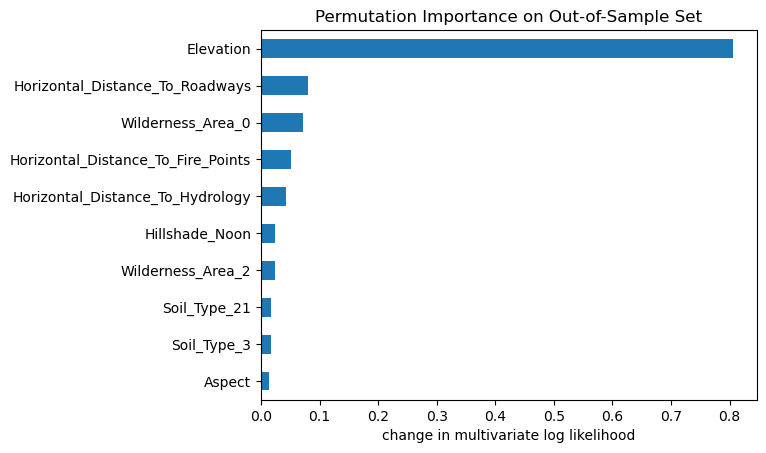

In [ ]:
#| fig-alt: horizontal bar plot showing permutation feature importance
#| fig-cap: top 10 features by permutation importance on validation set

importances_permutation = pd.Series(permu_imp['importances_mean'], index=features)
importances_permutation.sort_values(ascending=True)[-10:].plot.barh()
plt.title('Permutation Importance on Out-of-Sample Set')
plt.xlabel('change in multivariate log likelihood');


It looks like the model relies on elevation much more than any  other feature to make predictions on a held-out validation set.

## Wrapping Up

Ok, hopefully now you're comfortable with the nuts and bolts of training XGBoost classifiers on both binary and multi-class problems. 
If you found this useful, or if you have additional insights into using XGBoost to solve classification problems, let us know about it down in the comments!